# Example: Portfolio Optimization with ESG constraints

**Key Modifications:**
- **Data Preparation**: Sustainability data is fetched, and the filtered list of stocks is created based on the specified ESG thresholds.
- **Portfolio Calculation**: The code calculates optimal portfolios and efficient frontiers for both the original and ESG-filtered sets of stocks.
- **Plotting** with `rp.plot_frontier`:
    - The efficient frontier of the original portfolio is plotted with `rp.plot_frontier` using specified parameters.
    - The filtered portfolio's frontier is added to the same plot using a distinct colour.
    - **Combined Plot**: Both frontiers are plotted on the same graph, allowing for direct visual comparison.

In [1]:
from datetime import datetime, timedelta  # needed for date and time operations and date and time maths
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
pd.options.display.float_format = '{:.4}'.format  # display numeric values in Pandas up to 4 decimal points only

import yfinance as yf  # for data download from YahooFinance
import warnings  # manage Python warnings (to mute and/or ignore)
warnings.filterwarnings("ignore")

import riskfolio as rp

In [2]:
print(rp.__version__)

7.0.1


In [3]:
# Select stocks by specifying tickers of assets
assets = ['DELL', 'ABNB', 'PANW', 'BKNG', 'UBER', 'IBM', 'SCCO', 'ADBE',
          'NFLX', 'SAP', 'TXN', 'ORCL', 'TTD', 'MU', 'PYPL', 'INTC',
          'GOOG', 'MSFT', 'NVDA', 'AMZN', 'META', 'TSLA', 'AAPL', 'AMD', 'CRM']

# Select the time period for analysis
start = '2020-01-01'
end = '2024-07-26'

# Downloading data
data = yf.download(assets, start = start, end = end, group_by="ticker")
data = pd.concat([data[ticker]['Close'] for ticker in assets], axis=1)
data.columns = assets

# Calculating returns
Y = data[assets].pct_change().dropna()

[*********************100%***********************]  25 of 25 completed


In [4]:
# Fetching sustainability scores for the stocks
sustainability_data = []

for stock in assets:
    try:
        ticker = yf.Ticker(stock)
        sustainability = ticker.sustainability
        environment_score = sustainability.loc['environmentScore'].values[0]
        social_score = sustainability.loc['socialScore'].values[0]
        governance_score = sustainability.loc['governanceScore'].values[0]
        sustainability_data.append([stock, environment_score, social_score, governance_score])
    except:
        # If data is missing or not available, append None values
        sustainability_data.append([stock, None, None, None])
        print(f"Sustainability data is unavailable for {stock} :(")

# Convert sustainability data to a DataFrame
sustainability_df = pd.DataFrame(sustainability_data, columns=['Stock', 'Env_Score', 'Soc_Score', 'Gov_Score'])

HTTP Error 404: 


Sustainability data is unavailable for SAP :(


HTTP Error 404: 


Sustainability data is unavailable for GOOG :(


In [5]:
sustainability_df

,Stock,Env_Score,Soc_Score,Gov_Score
0,DELL,2.31,7.0,4.56
1,ABNB,0.88,9.83,6.68
2,PANW,0.05,7.99,4.89
3,BKNG,0.83,9.33,4.39
4,UBER,3.74,12.16,5.81
5,IBM,1.58,6.68,5.01
6,SCCO,11.12,8.86,5.03
7,ADBE,2.78,6.75,4.71
8,NFLX,0.16,6.31,6.91
9,SAP,NaN,NaN,NaN


In [6]:
# display a quick summary of ESG data
with pd.option_context('display.float_format', '{:,.3f}'.format):
    display(sustainability_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Env_Score,23.000,3.987,3.331,0.050,1.945,3.040,4.160,11.120
Soc_Score,23.000,8.908,3.885,4.220,6.715,7.990,10.615,21.640
Gov_Score,23.000,5.686,1.458,3.740,4.635,5.030,6.795,8.680


In [7]:
# Define ESG thresholds (adjust these thresholds as needed)
env_threshold = 7
soc_threshold = 7
gov_threshold = 7

# Filter stocks based on ESG criteria
filtered_stocks = sustainability_df[
    (sustainability_df['Env_Score'] < env_threshold) &
    (sustainability_df['Soc_Score'] < soc_threshold) &
    (sustainability_df['Gov_Score'] < gov_threshold)
]['Stock'].tolist()

print(filtered_stocks)

['IBM', 'ADBE', 'NFLX', 'NVDA', 'AMD']


In [8]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio for the original set of stocks
method_mu = 'hist'
method_cov = 'hist'
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

model = 'Classic'
rm = 'MV'
obj = 'Sharpe'
rf = 0
l = 0
hist = True

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
points = 50

# Calculate efficient frontier for the original set of stocks
frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

Original (unconstrained) Frontier


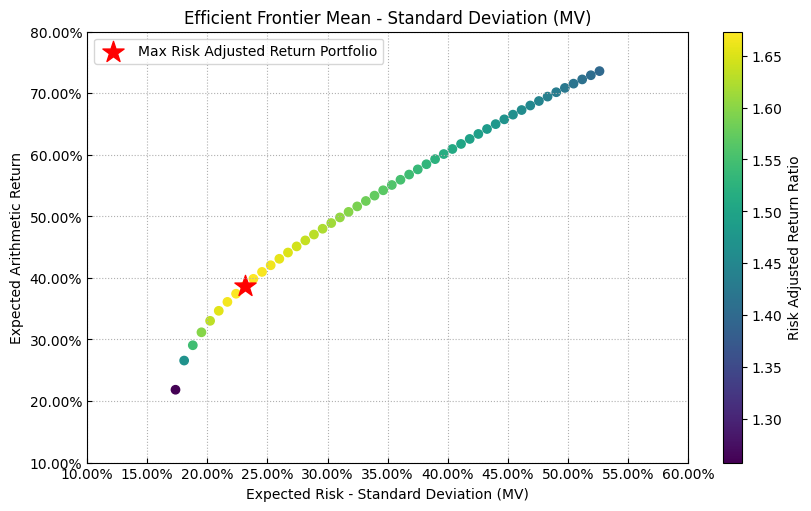

In [9]:
# Plot the original (unconstrained) frontier
print('Original (unconstrained) Frontier')

label = 'Max Risk Adjusted Return Portfolio' # Title of portfolio point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=5, width=8, t_factor=252, ax=None)

ESG-filtered Frontier


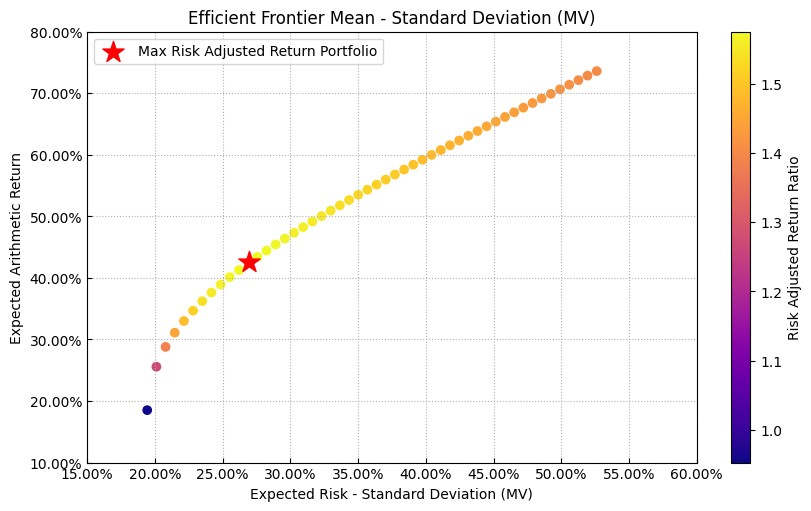

In [10]:
# Plot the filtered ESG frontier
print('ESG-filtered Frontier')

label = 'Max Risk Adjusted Return Portfolio'         # Title of portfolio point
Y_filtered = Y[filtered_stocks]                      # Subset the returns data to include only filtered stocks
port_filtered = rp.Portfolio(returns=Y_filtered)     # Building the portfolio object for the filtered stocks

# Calculating optimal portfolio for the filtered set of stocks
port_filtered.assets_stats(method_mu=method_mu, method_cov=method_cov)
w_filtered = port_filtered.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

# Calculate efficient frontier for the filtered set of stocks
frontier_filtered = port_filtered.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

ax = rp.plot_frontier(w_frontier=frontier_filtered, mu=port_filtered.mu, cov=port_filtered.cov, returns=Y_filtered, rm=rm,
                      rf=rf, alpha=0.05, cmap='plasma', w=w_filtered, label=label,
                      marker='*', s=16, c='r', height=5, width=8, t_factor=252, ax=None)

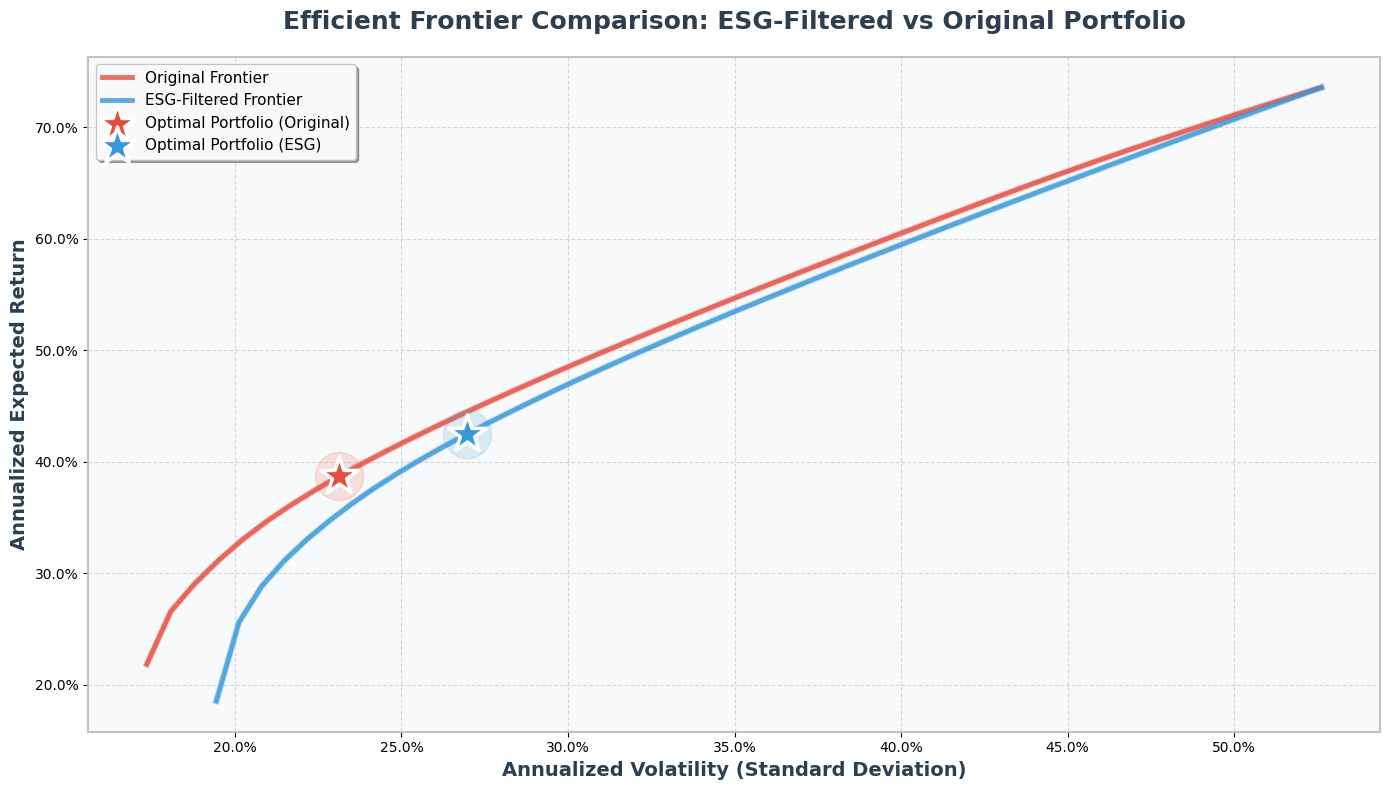

In [11]:
# Close any existing figures
plt.close('all')

# If filtered stocks are available, calculate the second frontier
if filtered_stocks:
    # Subset the returns data to include only filtered stocks
    Y_filtered = Y[filtered_stocks]
    # Building the portfolio object for the filtered stocks
    port_filtered = rp.Portfolio(returns=Y_filtered)
    # Calculating optimal portfolio for the filtered set of stocks
    port_filtered.assets_stats(method_mu=method_mu, method_cov=method_cov)
    w_filtered = port_filtered.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    # Calculate efficient frontier for the filtered set of stocks
    frontier_filtered = port_filtered.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
    
    # Create figure with custom styling
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Set style
    ax.set_facecolor('#f8f9fa')
    fig.patch.set_facecolor('white')
    
    # The frontier has assets as rows and portfolios as columns
    frontier_filtered_vals = frontier_filtered.values
    mu_filtered_vals = port_filtered.mu.values.flatten()
    cov_filtered_vals = port_filtered.cov.values
    
    # Calculate returns and risks for the filtered frontier
    mu_filtered = (frontier_filtered_vals.T @ mu_filtered_vals) * 252
    risk_filtered = np.sqrt(np.diag(frontier_filtered_vals.T @ cov_filtered_vals @ frontier_filtered_vals)) * np.sqrt(252)
    
    # Same for original frontier
    frontier_vals = frontier.values
    mu_original_vals = port.mu.values.flatten()
    cov_original_vals = port.cov.values
    
    mu_original = (frontier_vals.T @ mu_original_vals) * 252
    risk_original = np.sqrt(np.diag(frontier_vals.T @ cov_original_vals @ frontier_vals)) * np.sqrt(252)
    
    # Plot both frontiers with gradient effect
    ax.plot(risk_original, mu_original, linewidth=3.5, label='Original Frontier', 
            color='#e74c3c', alpha=0.8, zorder=2)
    ax.plot(risk_filtered, mu_filtered, linewidth=3.5, label='ESG-Filtered Frontier', 
            color='#3498db', alpha=0.8, zorder=2)
    
    # Add subtle shadow effect
    ax.plot(risk_original, mu_original, linewidth=5, color='#e74c3c', alpha=0.2, zorder=1)
    ax.plot(risk_filtered, mu_filtered, linewidth=5, color='#3498db', alpha=0.2, zorder=1)
    
    # Plot optimal portfolios with enhanced styling
    w_filtered_vals = w_filtered.values.flatten()
    mu_w_filtered = (w_filtered_vals @ mu_filtered_vals) * 252
    risk_w_filtered = np.sqrt(w_filtered_vals @ cov_filtered_vals @ w_filtered_vals) * np.sqrt(252)
    
    w_vals = w.values.flatten()
    mu_w_original = (w_vals @ mu_original_vals) * 252
    risk_w_original = np.sqrt(w_vals @ cov_original_vals @ w_vals) * np.sqrt(252)
    
    # Plot stars with glow effect
    ax.scatter(risk_w_original, mu_w_original, marker='*', s=800, c='#e74c3c', 
               edgecolors='white', linewidths=2.5, label='Optimal Portfolio (Original)', 
               zorder=5)
    ax.scatter(risk_w_filtered, mu_w_filtered, marker='*', s=800, c='#3498db', 
               edgecolors='white', linewidths=2.5, label='Optimal Portfolio (ESG)', 
               zorder=5)
    
    # Add glow around optimal points
    ax.scatter(risk_w_original, mu_w_original, marker='o', s=1200, c='#e74c3c', 
               alpha=0.15, zorder=4)
    ax.scatter(risk_w_filtered, mu_w_filtered, marker='o', s=1200, c='#3498db', 
               alpha=0.15, zorder=4)
    
    # Enhanced labels and title
    ax.set_xlabel('Annualized Volatility (Standard Deviation)', fontsize=14, 
                  fontweight='bold', color='#2c3e50')
    ax.set_ylabel('Annualized Expected Return', fontsize=14, 
                  fontweight='bold', color='#2c3e50')
    ax.set_title('Efficient Frontier Comparison: ESG-Filtered vs Original Portfolio', 
                 fontsize=18, fontweight='bold', color='#2c3e50', pad=20)
    
    # Enhanced grid
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8, color='#7f8c8d')
    ax.set_axisbelow(True)
    
    # Format axes as percentages
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.1f}%'))
    
    # Enhanced legend
    legend = ax.legend(loc='upper left', fontsize=11, frameon=True, 
                      shadow=True, fancybox=True, framealpha=0.95)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('#bdc3c7')
    
    # Add subtle border
    for spine in ax.spines.values():
        spine.set_edgecolor('#bdc3c7')
        spine.set_linewidth(1.5)
    
    # Tight layout
    plt.tight_layout()
    plt.show()
else:
    print("No stocks meet the specified ESG criteria.")

In [12]:
portfolio_returns = (Y @ w).squeeze()
portfolio_returns_filtered = (Y_filtered @ w_filtered).squeeze()

# Create the original returns DataFrame
daily_returns = pd.DataFrame({
    'Original': portfolio_returns,
    'Filtered': portfolio_returns_filtered
})

# Calculate cumulative returns
cumulative_comparison = (1 + daily_returns).cumprod() - 1

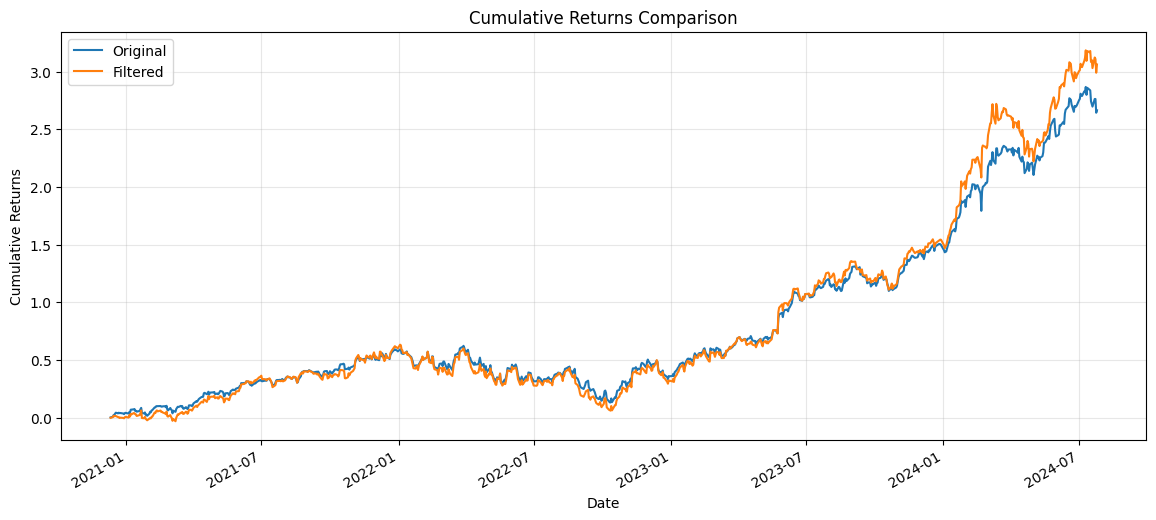

In [13]:
# Plot
cumulative_comparison.plot(figsize=(14, 6), title='Cumulative Returns Comparison')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

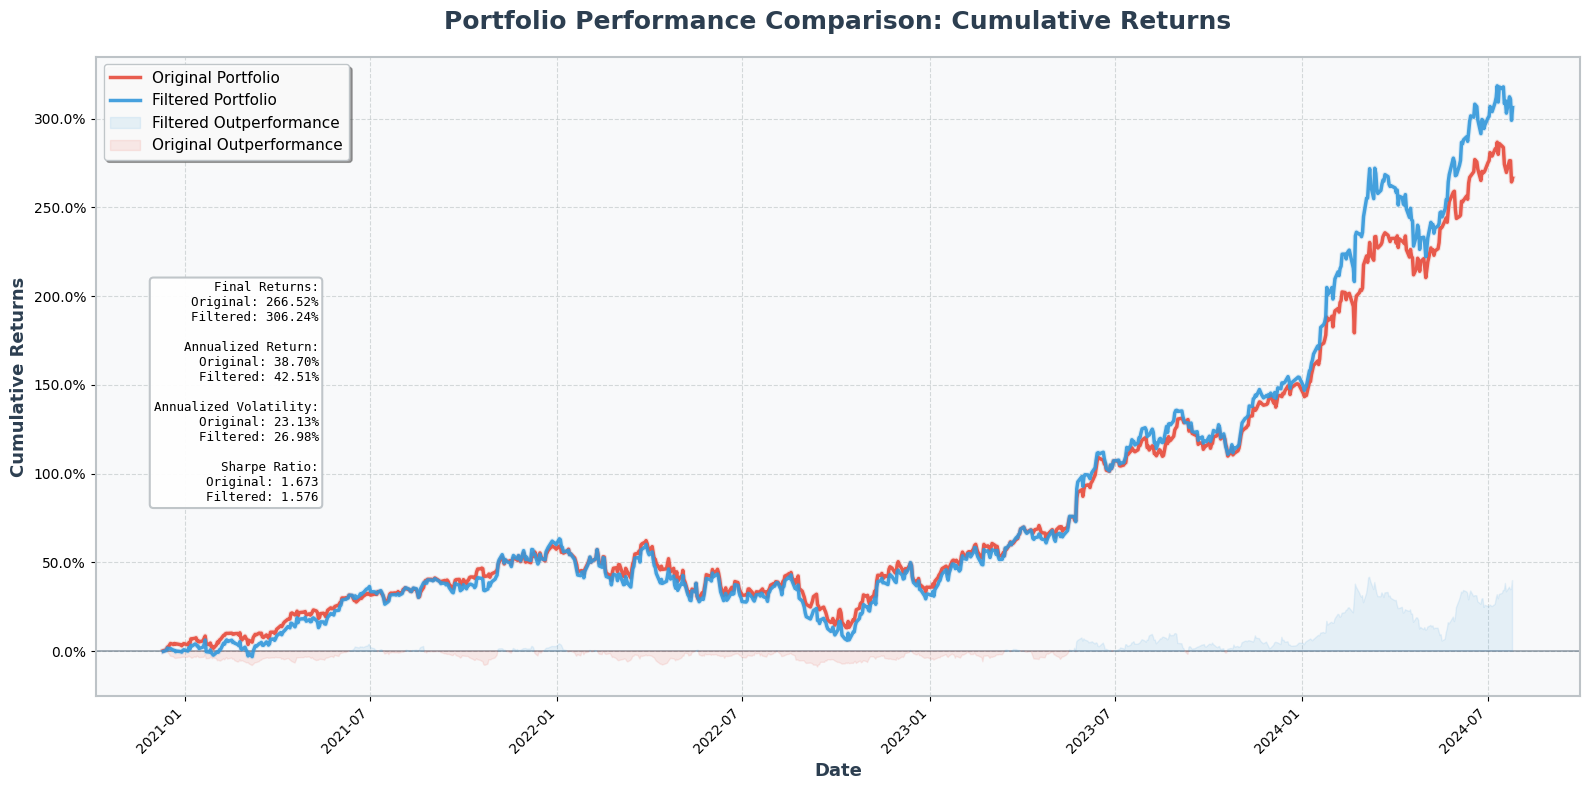

In [14]:
# Create figure with custom styling
fig, ax = plt.subplots(figsize=(16, 8))

# Set style
ax.set_facecolor('#f8f9fa')
fig.patch.set_facecolor('white')

# Define colors
colors = {
    'Original': '#e74c3c',      # Red
    'Filtered': '#3498db'        # Blue
}

# Plot each series with enhanced styling
for col in cumulative_comparison.columns:
    # Main line
    ax.plot(cumulative_comparison.index, 
           cumulative_comparison[col],
           label=col + ' Portfolio',
           color=colors.get(col, '#2c3e50'),
           linewidth=2.5,
           alpha=0.9,
           zorder=3)
    
    # Shadow effect
    ax.plot(cumulative_comparison.index, 
           cumulative_comparison[col],
           color=colors.get(col, '#2c3e50'),
           linewidth=4,
           alpha=0.15,
           zorder=2)

# Add horizontal line at y=0
ax.axhline(y=0, color='#34495e', linestyle='-', linewidth=1.2, alpha=0.5, zorder=1)

# Fill areas to show outperformance/underperformance
if 'Original' in cumulative_comparison.columns and 'Filtered' in cumulative_comparison.columns:
    diff = cumulative_comparison['Filtered'] - cumulative_comparison['Original']
    ax.fill_between(cumulative_comparison.index, 0, diff,
                    where=(diff >= 0), alpha=0.1, color='#3498db',
                    interpolate=True, label='Filtered Outperformance')
    ax.fill_between(cumulative_comparison.index, 0, diff,
                    where=(diff < 0), alpha=0.1, color='#e74c3c',
                    interpolate=True, label='Original Outperformance')

# Enhanced title and labels
ax.set_title('Portfolio Performance Comparison: Cumulative Returns', 
            fontsize=18, fontweight='bold', color='#2c3e50', pad=20)
ax.set_xlabel('Date', fontsize=13, fontweight='bold', color='#2c3e50')
ax.set_ylabel('Cumulative Returns', fontsize=13, fontweight='bold', color='#2c3e50')

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))

# Enhanced grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8, color='#7f8c8d', zorder=0)
ax.set_axisbelow(True)

# Enhanced legend
legend = ax.legend(loc='upper left', fontsize=11, frameon=True,
                  shadow=True, fancybox=True, framealpha=0.95,
                  edgecolor='#bdc3c7', facecolor='white')

# Add statistics box using the ORIGINAL daily returns
final_returns = cumulative_comparison.iloc[-1]
stats_text = "Final Returns:\n"
for col in cumulative_comparison.columns:
    stats_text += f"{col}: {final_returns[col]*100:.2f}%\n"

# Calculate annualized returns and volatility from original daily returns
ann_returns = (daily_returns.mean() * 252 * 100)
ann_vol = (daily_returns.std() * np.sqrt(252) * 100)
sharpe = ann_returns / ann_vol

stats_text += f"\nAnnualized Return:\n"
for col in daily_returns.columns:
    stats_text += f"{col}: {ann_returns[col]:.2f}%\n"

stats_text += f"\nAnnualized Volatility:\n"
for col in daily_returns.columns:
    stats_text += f"{col}: {ann_vol[col]:.2f}%\n"

stats_text += f"\nSharpe Ratio:\n"
for col in daily_returns.columns:
    stats_text += f"{col}: {sharpe[col]:.3f}\n"

# Add text box with statistics
props = dict(boxstyle='round', facecolor='white', alpha=0.95, 
            edgecolor='#bdc3c7', linewidth=1.5)
ax.text(0.15, 0.3, stats_text.strip(), transform=ax.transAxes,
       fontsize=9, verticalalignment='bottom', horizontalalignment='right',
       bbox=props, family='monospace')

# Style spines
for spine in ax.spines.values():
    spine.set_edgecolor('#bdc3c7')
    spine.set_linewidth(1.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Tight layout
plt.tight_layout()
plt.show()

# Create helper functions to get the results and plots quicker

In [15]:
def create_and_plot_frontier(returns, filtered_stocks=None, 
                             method_mu='hist', method_cov='hist',
                             model='Classic', rm='MV', obj='Sharpe',
                             rf=0, l=0, hist=True, points=50,
                             cmap='viridis', marker_color='r',
                             height=5, width=8, t_factor=252,
                             title=None, ax=None):
    """
    Create and plot an efficient frontier for a portfolio.
    
    Parameters
    ----------
    returns : pd.DataFrame
        Returns data for all stocks
    filtered_stocks : list, optional
        List of stock tickers to filter. If None, uses all stocks.
    method_mu : str, default 'hist'
        Method to calculate expected returns
    method_cov : str, default 'hist'
        Method to calculate covariance matrix
    model : str, default 'Classic'
        Portfolio optimization model
    rm : str, default 'MV'
        Risk measure
    obj : str, default 'Sharpe'
        Objective function
    rf : float, default 0
        Risk-free rate
    l : float, default 0
        Risk aversion factor
    hist : bool, default True
        Use historical scenarios
    points : int, default 50
        Number of points on the efficient frontier
    cmap : str, default 'viridis'
        Colormap for the frontier
    marker_color : str, default 'r'
        Color of the optimal portfolio marker
    height : int, default 5
        Figure height
    width : int, default 8
        Figure width
    t_factor : int, default 252
        Time factor for annualization
    title : str, optional
        Custom title for the plot
    ax : matplotlib.axes.Axes, optional
        Axes object to plot on
    
    Returns
    -------
    tuple
        (port, w, frontier, ax) - Portfolio object, optimal weights, frontier, and axes
    """
    # Filter returns if needed
    if filtered_stocks is not None:
        returns_data = returns[filtered_stocks]
        plot_title = title or 'ESG-Filtered Efficient Frontier'
    else:
        returns_data = returns
        plot_title = title or 'Original Efficient Frontier'
    
    # Build portfolio
    port = rp.Portfolio(returns=returns_data)
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)
    
    # Optimize
    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    
    # Calculate frontier
    frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
    
    # Plot
    label = 'Max Risk Adjusted Return Portfolio'
    ax = rp.plot_frontier(w_frontier=frontier, 
                         mu=port.mu, 
                         cov=port.cov, 
                         returns=returns_data, 
                         rm=rm,
                         rf=rf, 
                         alpha=0.05, 
                         cmap=cmap, 
                         w=w, 
                         label=label,
                         marker='*', 
                         s=16, 
                         c=marker_color, 
                         height=height, 
                         width=width, 
                         t_factor=t_factor, 
                         ax=ax)
    
    if title:
        ax.set_title(plot_title, fontsize=14, fontweight='bold', pad=15)
    
    print(f'Plotted: {plot_title}')
    
    return port, w, frontier, ax

Plotted: Original Efficient Frontier


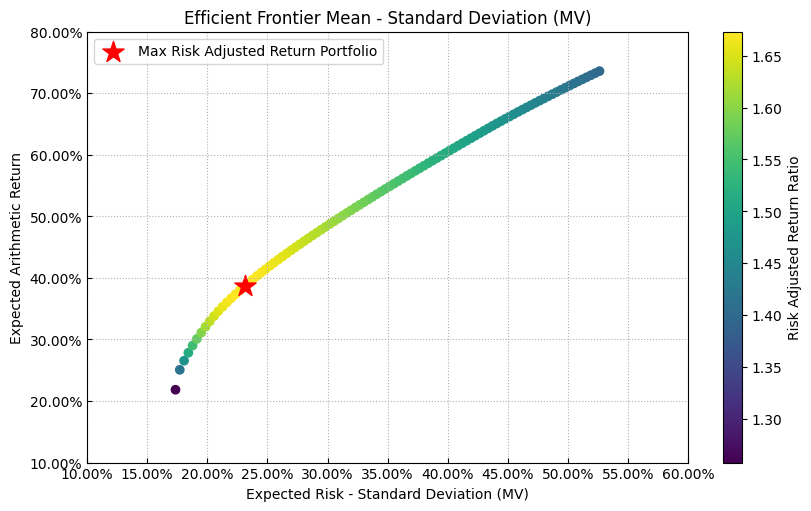

In [16]:
# USAGE EXAMPLES:

# Example 1: Plot original frontier
port, w, frontier, ax = create_and_plot_frontier(Y, points=100)

In [17]:
filtered_stocks

['IBM', 'ADBE', 'NFLX', 'NVDA', 'AMD']

Plotted: ESG-Filtered Efficient Frontier


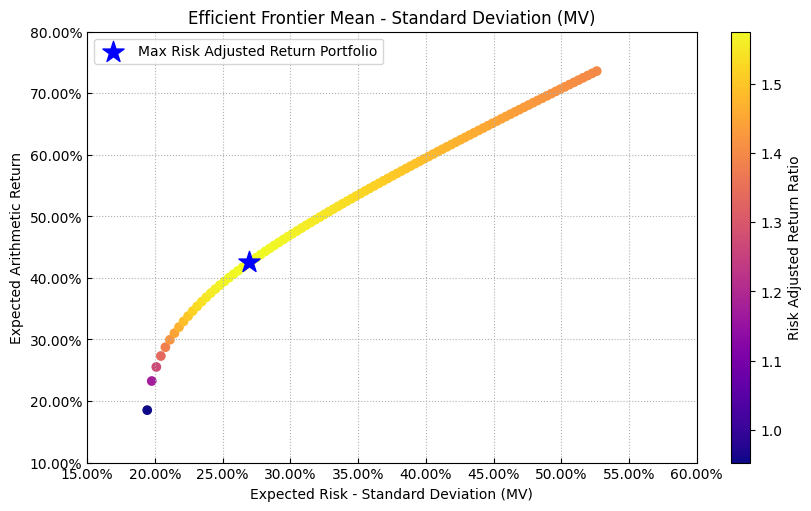

In [18]:
# Example 2: Plot ESG-filtered frontier
port_filtered, w_filtered, frontier_filtered, ax = create_and_plot_frontier(
    Y, points=100,
    filtered_stocks=filtered_stocks,
    cmap='plasma', marker_color='b')